### Model U-net architecture

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

In [2]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3,1,1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3,1,1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

In [3]:
class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64,128,256,512],):
        super(UNET,self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
        # Down Part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature #pass to next level
    
        # Up Part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2,feature))
    
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0],out_channels, kernel_size=1)
    
    def forward(self, x):
        skip_connections = []
    
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
    
        x = self.bottleneck(x)
    
        skip_connections = skip_connections[::-1] #reverse the connection
            
        for idx in range(0,len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if(x.shape != skip_connection.shape):
                x = TF.resize(x, size=skip_connection.shape[2:])
                
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)
                
        return self.final_conv(x)

In [4]:
def test():
    x = torch.randn((3,1,160,160))
    model = UNET(in_channels=1, out_channels=1)
    preds = model(x)
    print(preds.shape)
    print(x.shape)
    assert preds.shape == x.shape

In [5]:
if __name__ == "__main__":
    test()

torch.Size([3, 1, 160, 160])
torch.Size([3, 1, 160, 160])


### Dataset 

In [6]:
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np

In [7]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class Carvana(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        # Load image and mask
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace(".jpg", "_mask.gif"))
        
        # Open image and mask as PIL images
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Convert mask to grayscale

        # Convert mask to numpy array and set appropriate values (0 for background, 1 for object)
        mask = np.array(mask, dtype=np.float32)
        mask[mask == 255.0] = 1.0

        # Apply resize transformation if provided
        if self.transform:
            image = self.transform(image)
            mask = Image.fromarray(mask)
            mask = self.transform(mask)

        # Convert image to tensor
        image = transforms.ToTensor()(image)
        
        # Convert mask to tensor
        mask = np.array(mask, dtype=np.float32)
        mask = torch.tensor(mask, dtype=torch.float32)

        return image, mask

### Training

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm

In [9]:
LEARNING_RATE = 1e-4
BATCH_SIZE = 1
NUM_EPOCHS = 20
shuffle=True
pin_memory=True
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_WORKERS = 1
IMAGE_DIR = "data/train"
MASK_DIR = "data/train_masks"

In [10]:
transform = transforms.Compose([
    transforms.Resize((160, 160)),
])

In [11]:
def dice_loss(pred, target):
    smooth = 1.0
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    return 1 - (2.0 * intersection + smooth) / (union + smooth)

train_dataset = Carvana(
    image_dir=IMAGE_DIR,
    mask_dir=MASK_DIR,
    transform=transform  # Add augmentation logic if needed
)
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
    pin_memory=True
)

In [12]:
model = UNET(in_channels=3, out_channels=1).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()

In [13]:
def train():
    model.train()
    loop = tqdm(train_loader, leave=True)
    total_loss = 0

    for batch_idx, (images, masks) in enumerate(loop):
        print(f"Batch {batch_idx + 1}/{len(train_loader)}")  # Log batch progress

        # Move data to the appropriate device
        images = images.to(DEVICE, dtype=torch.float32)
        masks = masks.to(DEVICE, dtype=torch.float32)

        # Check if images and masks are valid
        if images.size(0) == 0 or masks.size(0) == 0:
            print(f"Skipping empty batch {batch_idx + 1}")
            continue  # Skip this batch if it's empty

        # Ensure masks have the correct shape
        masks = masks.unsqueeze(1)  # Add a channel dimension if needed

        # Forward pass
        predictions = model(images)

        # Check if predictions and masks have the correct shape
        if predictions.size(1) != masks.size(1):  # Ensure they match
            print(f"Shape mismatch: predictions {predictions.size()}, masks {masks.size()}")
            continue  # Skip this batch if there's a shape mismatch

        # Calculate the loss
        loss = criterion(predictions, masks) + dice_loss(predictions, masks)

        # Add the loss to the total loss
        total_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update progress bar
        loop.set_postfix(loss=loss.item())
        
        # Clear batch data
        del images, masks, predictions, loss
        torch.cuda.empty_cache()

    print(f"Epoch Loss: {total_loss / len(train_loader)}")

In [14]:
# for epoch in range(NUM_EPOCHS):
#     print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}]")
#     train()

### Evaluating

In [15]:
model.load_state_dict(torch.load("unet.pth"))


C:\Users\MANN\AppData\Local\Temp\ipykernel_17788\4081212980.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("unet.pth"))


<All keys matched successfully>

In [20]:
from torch.utils.data import Subset
test_indices = list(range(20)) 
test_dataset = Subset(train_dataset, test_indices)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=0,
    shuffle=False,
    pin_memory=True
)

In [21]:
if len(test_loader) == 0:
    print("Error: test_loader is empty!")
print(f"Test loader has {len(test_loader)} batches.")  # Debugging line

Test loader has 20 batches.


In [22]:
def test():
    model.eval() 
    total_loss = 0
    dice_score = 0

    with torch.no_grad():
        print("Testing Started")
        for batch_idx, (images, masks) in enumerate(test_loader):
            print(f"Testing Batch {batch_idx + 1}/{len(test_loader)}")

            images = images.to(DEVICE, dtype=torch.float32)
            masks = masks.to(DEVICE, dtype=torch.float32)

            masks = masks.unsqueeze(1) 

            predictions = model(images)

            loss = criterion(predictions, masks) + dice_loss(predictions, masks)
            total_loss += loss.item()

            predictions = torch.sigmoid(predictions)
            predictions = (predictions > 0.5).float()
            intersection = (predictions * masks).sum(dim=(2, 3))
            union = predictions.sum(dim=(2, 3)) + masks.sum(dim=(2, 3))
            dice = (2 * intersection + 1) / (union + 1) 
            dice_score += dice.mean().item()

            print(f"Batch {batch_idx + 1} - Loss: {loss.item()}")

            del images, masks, predictions, loss
            torch.cuda.empty_cache()

    print(f"Testing Loss: {total_loss / len(test_loader)}")
    print(f"Average Dice Score: {dice_score / len(test_loader)}")


In [23]:
test()

Testing Started
Testing Batch 1/20
Batch 1 - Loss: 0.03474540635943413
Testing Batch 2/20
Batch 2 - Loss: 0.030969474464654922
Testing Batch 3/20
Batch 3 - Loss: 0.03049839660525322
Testing Batch 4/20
Batch 4 - Loss: 0.031944870948791504
Testing Batch 5/20
Batch 5 - Loss: 0.03305685520172119
Testing Batch 6/20
Batch 6 - Loss: 0.03188982605934143
Testing Batch 7/20
Batch 7 - Loss: 0.02892661839723587
Testing Batch 8/20
Batch 8 - Loss: 0.029902536422014236
Testing Batch 9/20
Batch 9 - Loss: 0.03206203877925873
Testing Batch 10/20
Batch 10 - Loss: 0.03031235560774803
Testing Batch 11/20
Batch 11 - Loss: 0.02932717092335224
Testing Batch 12/20
Batch 12 - Loss: 0.030852999538183212
Testing Batch 13/20
Batch 13 - Loss: 0.03373514115810394
Testing Batch 14/20
Batch 14 - Loss: 0.03193463757634163
Testing Batch 15/20
Batch 15 - Loss: 0.030960123986005783
Testing Batch 16/20
Batch 16 - Loss: 0.03078872337937355
Testing Batch 17/20
Batch 17 - Loss: 0.03694711998105049
Testing Batch 18/20
Batch 18

### Prediction

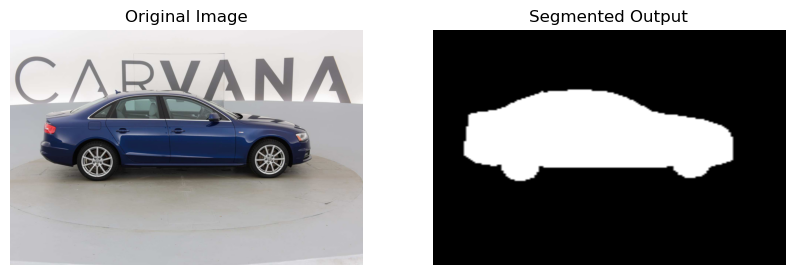

In [38]:
from PIL import Image
import matplotlib.pyplot as plt
import cv2

def segment_and_display_image(image_path, output_dir="outputs"):
    os.makedirs(output_dir, exist_ok=True)
    
    image = Image.open(image_path).convert("RGB")
    
    transform = transforms.Compose([
        transforms.Resize((160, 160)),
        transforms.ToTensor()
    ])
    
    image_tensor = transform(image).unsqueeze(0)
    image_tensor = image_tensor.to(DEVICE, dtype=torch.float32)

    model.eval()
    with torch.no_grad():
        prediction = model(image_tensor)

    prediction = torch.sigmoid(prediction)
    prediction = (prediction > 0.5).float()

    prediction = prediction.squeeze().cpu().numpy()

    prediction_resized = cv2.resize(prediction, (image.width, image.height))

    output_path = os.path.join(output_dir, os.path.basename(image_path))
    cv2.imwrite(output_path, prediction_resized * 255)

    original_image = np.array(image)

    # Use matplotlib to display images
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(prediction_resized, cmap='gray')
    plt.title("Segmented Output")
    plt.axis("off")

    plt.show()

segment_and_display_image("D:/Research/CV/Image-Segmentation/data/train/0cdf5b5d0ce1_13.jpg")